In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [3]:
!pip install deepxde
import re

import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from matplotlib import cm
import scipy.io
import tensorflow as tf

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



In [4]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Data

In [5]:
import numpy as np
import matplotlib.pyplot as plt

F_data = {}

for i in range(10):
    F_data[i] = np.genfromtxt(f"/content/drive/MyDrive/PIPE Control/Pendulum/F_grid_time_horizon{i+1}.csv", delimiter=',')

N = np.shape(F_data[0])[1]

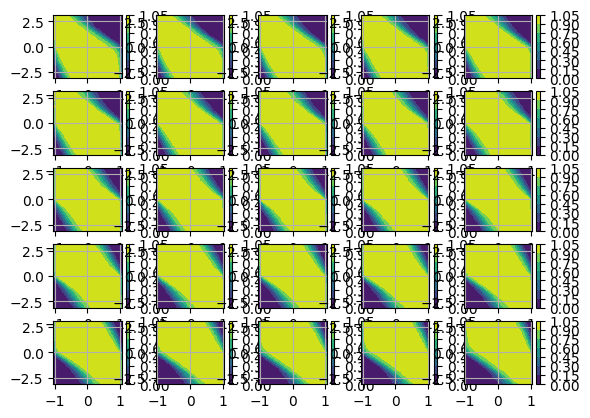

In [6]:
idx = 9

F_grid = np.zeros([10, N, N, N])

for i in range(10):
    for j in range(N):
        F_grid[i, j] = F_data[i][N*j : N*(j + 1), :]


v = np.linspace(-10, 10, N)
theta = np.linspace(-np.pi/3, np.pi/3, N)
theta_vel = np.linspace(-np.pi, np.pi, N)

xx, yy = np.meshgrid(theta, theta_vel)

plt.figure()

for i in range(N):

    plt.subplot(5, 5, i+1)

    plt.contourf(xx, yy, F_grid[idx, i].T)

    plt.grid()

    # if i % 5 == 4:
    plt.colorbar()

#### Training data with ICBC

In [7]:
observe_x_data = np.mgrid[0.1:1.1:0.1, -10:10:25j, -np.pi/3:np.pi/3:25j, -np.pi:np.pi:25j][:, :,::2,::2,::2].reshape(4,-1).T
observe_x_data.shape # (21970, 4)

observe_func_data = F_grid[:,::2,::2,::2].reshape(1,-1).T
observe_func_data.shape # (21970, 1)


bnd1_x = np.mgrid[0.1:1.1:0.1, -20:20:25j, -np.pi/3:-np.pi/3+0.1:1, -np.pi:np.pi:25j][:,::2,::2,::2].reshape(4,-1).T # boundary condition
bnd2_x = np.mgrid[0.1:1.1:0.1, -20:20:25j, np.pi/3:np.pi/3+0.1:1, -np.pi:np.pi:25j][:,::2,::2,::2].reshape(4,-1).T # boundary condition
bnd1_x.shape # (1625, 4)

bnd_func = np.zeros([3250,1])

observe_x = np.vstack([observe_x_data, bnd1_x, bnd2_x])
observe_func = np.vstack([observe_func_data, bnd_func])
observe_x.shape # (22470, 4)
observe_func.shape # (22470, 1) / (25220, 1)

(25220, 1)

/tmp/ipython-input-1443661777.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ha.scatter(X, Y, train_data[t,k,:,:], cmap=cm.coolwarm) # X: time, Y: state


Text(0.5, 0.92, 'training data')

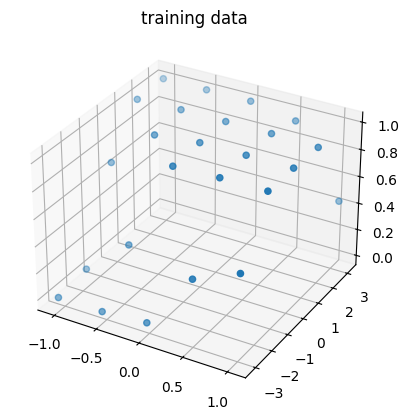

In [8]:
# x = np.linspace(-10,10,5)
x = np.linspace(-20,20,5)
y = np.linspace(-np.pi/3,np.pi/3,5)
z = np.linspace(-np.pi,np.pi,5)

X, Y = np.meshgrid(y, z)

k = 3
t = 7

train_data = F_grid[:,::5,::5,::5]

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.scatter(X, Y, train_data[t,k,:,:], cmap=cm.coolwarm) # X: time, Y: state
ha.set_title("training data")

### Pendulum system dynamics

$\dot x = f(x) + g(x)u$

$u = -Kx$

$f(x) = A^{-1}B$ and $g(x) = A^{-1}[0,1,0,0]^T$

In [9]:
# MatrixXf A(VectorXf x)
#     {
#         MatrixXf A_(4, 4);
#         A_ << 1, 0, 0, 0,
#               0, m+M, 0, m*l*cos(x(2)),
#               0, 0, 1, 0,
#               0, m*l*cos(x(2)), 0, m*l*l;
#         return A_;
#     }

#     VectorXf B(VectorXf x)
#     {
#         VectorXf B_(4);
#         B_ << x(1), m*l*sin(x(2))*x(3)*x(3) - bx*x(1), x(3), m*g*l*sin(x(2)) - bt*l*x(3);
#         return B_;
#     }

# VectorXf fs(VectorXf x)
#     {
#         return A(x).partialPivLu().solve(B(x));
#     }

#     VectorXf gs(VectorXf x)
#     {
#         VectorXf a(4); a << 0, 1, 0, 0;
#         return A(x).partialPivLu().solve(a);
#     }

#     VectorXf f_sys(VectorXf x, float u)
#     {
#         return fs(x) + gs(x)*u + S*normalRV();
#     }

#     float ctrl(VectorXf x)
#     {
#         return -1*K_gain.dot(x) * (abs(x(2)) <= theta_max);
#     }

# K_gain <<  -0.31622777*0,  -1.82975212, -44.32729537, -28.79844022;

# K_gain /= 2.0;

### PDE for pendulum system

In [10]:
# parameters
[K1, K2, K3, K4, K5, K6, K7, K8, K9, C] = [5.67e+00, 1.28e+01, 2.17e+00, -4.53e-01, 1.48e+00, 7.96e+00, 8.44e-01, -4.33e-01, 1.73e+00, 6.08e+00]

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=0) # T
    dy_x1 = dde.grad.jacobian(y, x, j=1) # v
    dy_x2 = dde.grad.jacobian(y, x, j=2) # theta
    dy_x3 = dde.grad.jacobian(y, x, j=3) # dot theta
    dy_xx1 = dde.grad.hessian(y, x, i=1, j=1)
    dy_xx2 = dde.grad.hessian(y, x, i=2, j=2)
    dy_xx3 = dde.grad.hessian(y, x, i=3, j=3)

    # no x in the dynamics because it is not considered
    t = x[:, 0:1]
    v = x[:, 1:2]
    theta = x[:, 2:3]
    w = x[:, 3:4]
    cos = tf.math.cos(theta)
    sin = tf.math.cos(theta)


    # full nonlinear dynamics
    return (
        dy_t
        - C * (dy_xx1 + dy_xx3) # only noise on velocities
        - (K6/(2.75-0.25*cos**2)*(K1*v+K2*w+K3*theta) + (0.5*v-K9*w*w*sin+cos*(w*(-1-2*theta)+9.8*sin))/(K5+cos**2)) * dy_x1
        - w * dy_x2
        - (K7*cos/(2.75-0.25*cos**2)*(K1*v+K2*w+K3*theta) + (K8*w*(2.2+4.4*theta)-K4*sin+cos*(-0.1*v+w*w*sin))/(K5+cos**2)) * dy_x3
    )

In [11]:
observe_y = dde.icbc.PointSetBC(observe_x, observe_func, component=0)

geom = dde.geometry.Cuboid([-20, -np.pi/3, -np.pi], [20, np.pi/3, np.pi])
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [observe_y],
    num_domain=800,
    anchors=observe_x,
)

In [12]:
layer_size = [4] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile(
    "adam", lr=0.001, external_trainable_variables=[]
)
variable = dde.callbacks.VariableValue([], period=1000)
model.train(epochs=60000, callbacks=[variable])

Compiling model...
Building feed-forward neural network...
'build' took 0.111215 s

'compile' took 1.579667 s

Training model...

Step      Train loss              Test loss               Test metric
0         [3.11e+02, 1.67e+00]    [3.11e+02, 1.67e+00]    []  
0 []
1000      [3.68e-02, 1.78e-01]    [3.68e-02, 1.78e-01]    []  
1000 []
2000      [1.08e-02, 1.75e-01]    [1.08e-02, 1.75e-01]    []  
2000 []
3000      [5.50e-03, 1.72e-01]    [5.50e-03, 1.72e-01]    []  
3000 []
4000      [4.27e-03, 1.67e-01]    [4.27e-03, 1.67e-01]    []  
4000 []
5000      [8.81e-03, 1.43e-01]    [8.81e-03, 1.43e-01]    []  
5000 []
6000      [2.11e-02, 9.05e-02]    [2.11e-02, 9.05e-02]    []  
6000 []
7000      [1.64e-02, 6.10e-02]    [1.64e-02, 6.10e-02]    []  
7000 []
8000      [8.18e-03, 5.18e-02]    [8.18e-03, 5.18e-02]    []  
8000 []
9000      [5.15e-03, 4.80e-02]    [5.15e-03, 4.80e-02]    []  
9000 []
10000     [3.80e-03, 4.55e-02]    [3.80e-03, 4.55e-02]    []  
10000 []
11000     [3.20e-03, 

(<deepxde.model.LossHistory at 0x787e31937170>,
 <deepxde.model.TrainState at 0x787e3168dbb0>)

In [13]:
test_x = np.mgrid[0.1:1.1:0.1, -20:20:25j, -np.pi/3:np.pi/3:25j, -np.pi:np.pi:25j].reshape(4,-1).T
test_y = F_grid.reshape(-1,1)

yhat = model.predict(test_x)

yhat.shape

safety_predict = yhat.reshape(10,25,25,-1)

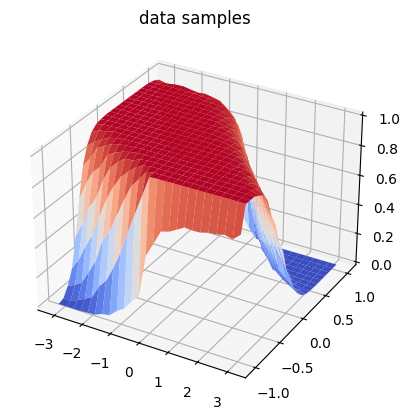

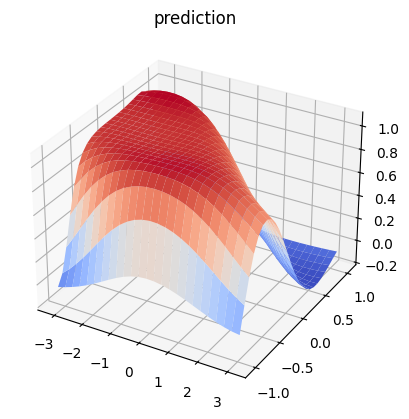

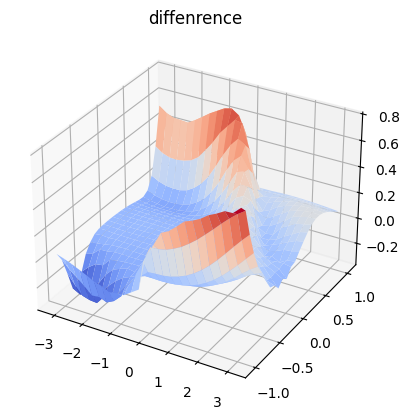

In [14]:
x = np.linspace(-20,20,25)
y = np.linspace(-np.pi/3,np.pi/3,25)
z = np.linspace(-np.pi,np.pi,25)

X, Y = np.meshgrid(z, y)

k = 2
t = 9

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, F_grid[t,k,:,:], cmap=cm.coolwarm) # X: time, Y: state
ha.set_title("data samples")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, safety_predict[t,k,:,:], cmap=cm.coolwarm) # X: time, Y: state
ha.set_title("prediction")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, F_grid[t,k,:,:]-safety_predict[t,k,:,:], cmap=cm.coolwarm) # X: time, Y: state
ha.set_title("diffenrence")
plt.show()

### Plotting

Clipped prediction between [0,1] and absolute error

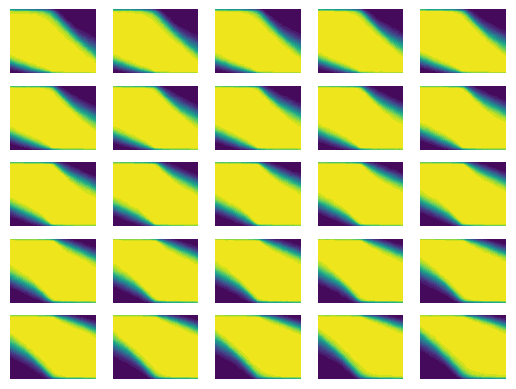

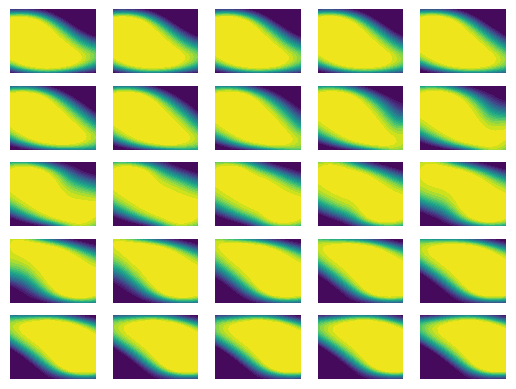

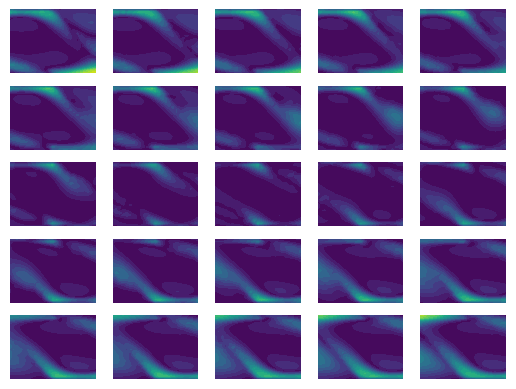

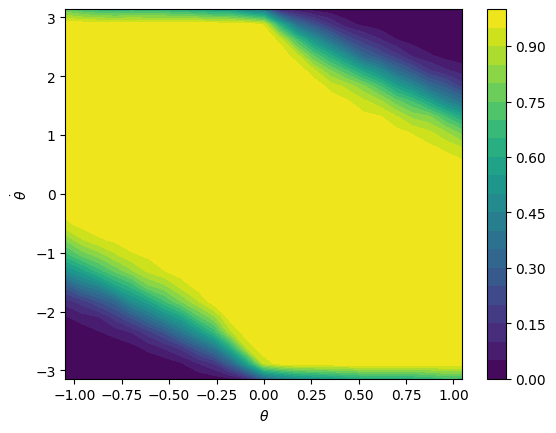

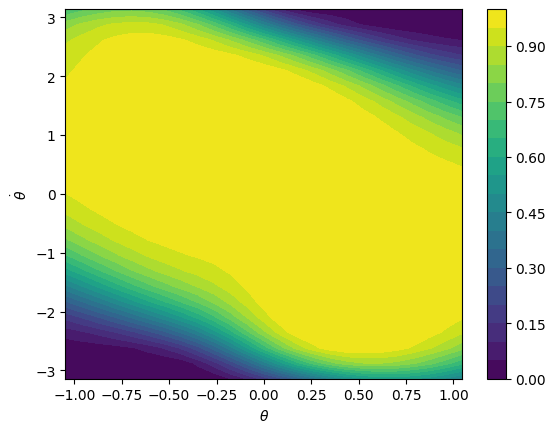

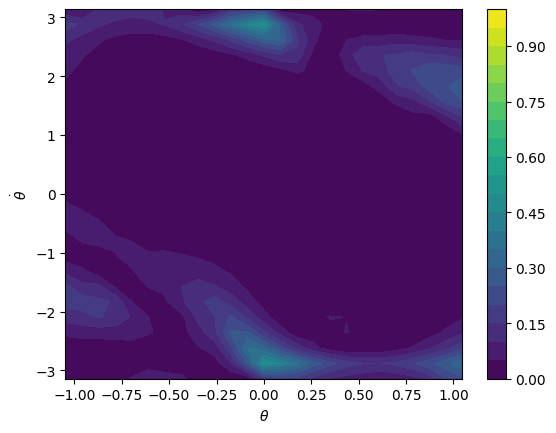

In [15]:
idx = 9

F_grid = np.zeros([10, N, N, N])
for i in range(10):
    for j in range(N):
        F_grid[i, j] = F_data[i][N*j : N*(j + 1), :]


v = np.linspace(-10, 10, N)
theta = np.linspace(-np.pi/3, np.pi/3, N)
theta_vel = np.linspace(-np.pi, np.pi, N)

xx, yy = np.meshgrid(theta, theta_vel)
levels = np.linspace(0, 1, 21)

# Plot the ground truth data
plt.figure()
for i in range(N):
    plt.subplot(5, 5, i+1)
    plt.contourf(xx, yy, F_grid[idx, i], levels=levels)
    plt.axis('off')
plt.savefig('data.pdf')

# Plot the predictions (clipped to [0,1])
plt.figure()
for i in range(N):
    plt.subplot(5, 5, i+1)
    plt.contourf(xx, yy, np.clip(safety_predict[idx, i], 0, 1), levels=levels)
    plt.axis('off')
plt.savefig('prediction.pdf')

# Plot the absolute error between data and prediction
plt.figure()
for i in range(N):
    plt.subplot(5, 5, i+1)
    plt.contourf(xx, yy, np.abs(F_grid[idx, i] - safety_predict[idx, i]), levels=levels)
    plt.axis('off')
plt.savefig('difference.pdf')

t = 5
k = 13

# Zoom in on a data slice
plt.figure()
plt.contourf(xx, yy, F_grid[t, k], levels=levels)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot \theta$')
plt.colorbar()
plt.savefig('zoomin.pdf')

# Zoom in on the prediction slice (clipped to [0,1])
plt.figure()
plt.contourf(xx, yy, np.clip(safety_predict[t, k], 0, 1), levels=levels)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot \theta$')
plt.colorbar()
plt.savefig('zoomin_predict.pdf')

# Zoom in on the absolute error slice
plt.figure()
plt.contourf(xx, yy, np.abs(F_grid[t, k] - safety_predict[t, k]), levels=levels)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot \theta$')
plt.colorbar()
plt.savefig('zoomin_difference.pdf')


Percentage error (clipped 100%)

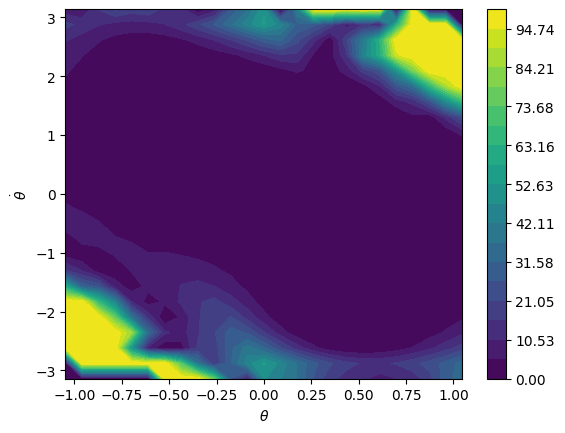

Average Percentage Error for idx = 3 : 18.734547035342363


In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Assume F_grid and safety_predict are already defined along with the other variables like N, xx, yy.

# Parameters and setup (using previously defined idx, t, k)
idx = 3
t = 5
k = 13

# Clip the predictions to [0, 1]
safe_pred_clipped = np.clip(safety_predict, 0, 1)

# Compute the percentage error.
# An epsilon is used in the denominator to avoid division by zero.
epsilon = 1e-6
percentage_error = 100 * np.abs(F_grid - safe_pred_clipped) / (np.abs(F_grid) + epsilon)

# Clip each percentage error value to be at most 100%
percentage_error = np.clip(percentage_error, 0, 100)

# -------------------------------
# Visualize Percentage Error (Full Grid)
# -------------------------------
plt.figure()
# Determine levels for percentage error dynamically from the idx slice data.
perc_levels = np.linspace(np.min(percentage_error[idx]), np.max(percentage_error[idx]), 20)
for i in range(N):
    plt.subplot(5, 5, i+1)
    plt.contourf(xx, yy, percentage_error[idx, i], levels=perc_levels)
    plt.axis('off')
plt.tight_layout()
plt.savefig('percentage_error.pdf')
plt.close()

# -------------------------------
# Zoom-In Visualization for Percentage Error
# -------------------------------
plt.figure()
zoom_perc_levels = np.linspace(np.min(percentage_error[t, k]), np.max(percentage_error[t, k]), 20)
plt.contourf(xx, yy, percentage_error[t, k], levels=zoom_perc_levels)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot \theta$')
plt.colorbar()
plt.savefig('zoomin_percentage_error.pdf')
plt.show()

# -------------------------------
# Calculate and Print the Average Percentage Error
# -------------------------------
# Average is taken over all points in the selected idx slice.
avg_percentage_error = np.mean(percentage_error[idx])
print("Average Percentage Error for idx =", idx, ":", avg_percentage_error)
